In [1]:
from collections import deque
import imageio
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import cv2

In [2]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [3]:
def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## main

In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')

SEED = 0
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
n_eval = env.spec.trials

# global values
total_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_solved = False

# load a model
target_net = DuelingDQN(obs_space, action_space).to(device)
target_net.load_state_dict(torch.load('LunarLander-v2_ep260_clear_model_dddqn.pt'))

/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
env.spec.max_episode_steps

1000

In [6]:
env.spec.trials

100

In [7]:
env.spec.reward_threshold

200

In [8]:
# env.metadata['video.frames_per_second'] = 60

In [9]:
# play
# frames = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         frames.append(env.render(mode = 'rgb_array'))
        env.render()
        action = select_action(obs, target_net)
        _obs, reward, done, _ = env.step(action)
        obs = _obs
        total_steps += 1
        ep_reward += reward     
    if done:
        env.render()
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))
#         frames.append(env.render(mode = 'rgb_array'))
#         imageio.mimsave(f'{env.spec.id}.gif', frames,)
        
        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in   206 steps, reward 197.28
  2 Episode in   393 steps, reward 225.83
  3 Episode in  1393 steps, reward 102.93
  4 Episode in  1724 steps, reward 247.68
  5 Episode in  1969 steps, reward 264.00
  6 Episode in  2218 steps, reward 233.77
  7 Episode in  2436 steps, reward 245.85
  8 Episode in  2646 steps, reward 205.13
  9 Episode in  2855 steps, reward 219.65
 10 Episode in  3029 steps, reward 224.32
 11 Episode in  3254 steps, reward 236.83
 12 Episode in  3478 steps, reward 231.02
 13 Episode in  3835 steps, reward 214.40
 14 Episode in  4021 steps, reward 215.86
 15 Episode in  4237 steps, reward 234.77
 16 Episode in  4456 steps, reward 210.23
 17 Episode in  4641 steps, reward 201.19
 18 Episode in  4832 steps, reward 223.21
 19 Episode in  5016 steps, reward 190.31
 20 Episode in  5542 steps, reward 191.04
 21 Episode in  6542 steps, reward -57.59
 22 Episode in  6772 steps, reward 234.02
 23 Episode in  6978 steps, reward 225.77
 24 Episode in  7176 steps, reward

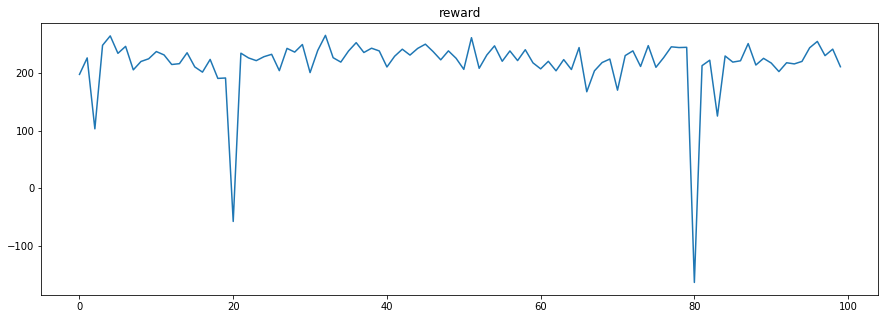

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.show()

In [11]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 452, 0.05),
    ('MountainCar-v0', 193, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 452, 0.05),
 ('MountainCar-v0', 193, 0.1),
 ('LunarLander-v2', 260, 0.1)]